必要パッケージのインストール

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from typing import Union

import numpy as np
import scipy

# 実空間一様グリッドの定義

In [3]:
xmin = -10
xmax = 10
Ngrid = 100
x_g = np.linspace(xmin, xmax, Ngrid)
dx = x_g[1] - x_g[0]
dx

0.20202020202020243

# ポテンシャルの定義
調和振動子 $V_{ext}(x)=(1/2)m\omega^2x^2, \omega=1$とする

In [4]:
def V_ext(x: Union[np.array, float]):
    return 0.5 * x**2

# 1体版_ハミルトニアン行列の定義
- 差分法にて∇^2を表現する。
- グリッドx_gの上で離散化し、波動関数をN_gridのサイズの配列として扱う。

In [5]:
H = np.zeros((Ngrid, Ngrid))
kin_diag = -0.5 * (-2.0 / dx**2)
kin_offdiag = -0.5 * (1.0 / dx**2)
for g in range(Ngrid):
    H[g, g] = kin_diag + V_ext(x_g[g])
    if g > 0:
        H[g, g - 1] = kin_offdiag
    if g < Ngrid - 1:
        H[g, g + 1] = kin_offdiag

print(H)

[[ 74.5025     -12.25125      0.         ...   0.           0.
    0.        ]
 [-12.25125     72.50270406 -12.25125    ...   0.           0.
    0.        ]
 [  0.         -12.25125     70.54372028 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  70.54372028 -12.25125
    0.        ]
 [  0.           0.           0.         ... -12.25125     72.50270406
  -12.25125   ]
 [  0.           0.           0.         ...   0.         -12.25125
   74.5025    ]]


# 対角化

In [6]:
%%time
e_i, psi_gi = np.linalg.eigh(H)
psi_ig = psi_gi.T
print(e_i)  # 固有エネルギー

[ 0.49872134  1.49359344  2.48330408  3.46781212  4.44707534  5.42105032
  6.38969245  7.35295586  8.31079332  9.26315623 10.2099945  11.15125653
 12.08688908 13.01683721 13.94104418 14.85945137 15.77199815 16.67862177
 17.57925724 18.47383721 19.3622918  20.24454845 21.12053175 21.99016325
 22.85336125 23.71004059 24.56011238 25.40348372 26.24005745 27.06973173
 27.89239975 28.70794926 29.51626211 30.31721378 31.1106727  31.89649967
 32.67454707 33.44465797 34.20666521 34.96039022 35.70564175 36.44221441
 37.169887   37.88842067 38.59755686 39.29701512 39.98649075 40.66565231
 41.33413875 41.99155581 42.63747067 43.27140324 43.89281135 44.50106535
 45.09540826 45.67487948 46.23826985 46.78360063 47.30968801 47.80619364
 48.29419617 48.66104177 49.21187432 49.31677637 50.1677322  50.17592412
 51.24017478 51.24050895 52.4347217  52.43473083 53.74562615 53.74562633
 55.17251037 55.17251037 56.71890825 56.71890825 58.39105301 58.39105301
 60.19762699 60.19762699 62.15003542 62.15003542 64

# 波動関数のプロット

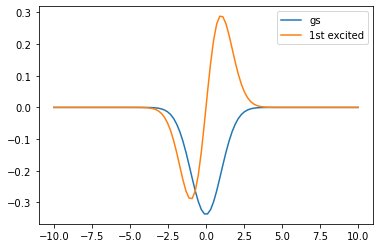

In [7]:
from matplotlib import pyplot as plt

plt.plot(x_g, psi_ig[0], label="gs")
plt.plot(x_g, psi_ig[1], label="1st excited")
plt.legend()

# 基底状態と第一励起状態のエネルギー差
理論値は $\hbar\omega = 1.0$

In [8]:
e_i[1] - e_i[0]

0.9948720991357451

# SciPyの疎行列ライブラリを使ってみる

In [9]:
from scipy import sparse
from scipy.sparse import csr_matrix
import scipy.sparse.linalg

H_csr = csr_matrix(H)  # Compressed Sparse Row matrix

In [10]:
%%time
es_i, psis_gi = scipy.sparse.linalg.eigsh(H_csr, k=10, which="SM")
psis_ig = psis_gi.T
es_i[1] - es_i[0]

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 12 ms


0.9948720991357463

sparseライブラリを使ったほうが圧倒的に早いことがわかる。
sparseの有無で波動関数の形を比較してみる

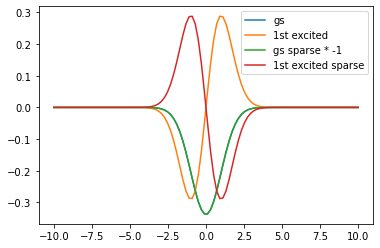

In [11]:
from matplotlib import pyplot as plt

plt.plot(x_g, psi_ig[0], label="gs")
plt.plot(x_g, psi_ig[1], label="1st excited")

plt.plot(
    x_g, psis_ig[0] * -1, label="gs sparse * -1"
)  # 位相の違いを打ち消すために-1をかけた
plt.plot(x_g, psis_ig[1], label="1st excited sparse")
plt.legend()

## (Optional)
- xmin, xmaxの値を小さくするとどうなるか
- Ngridの値を増減させるとどうなるか
- (難) 今回、境界条件は固定端とした。周期境界条件を課すにはどうすればいいか。